In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

In [2]:
%%writefile conda_dependencies.yml
dependencies:
    - python=3.6.9
    - numpy=1.18.*
    - pandas=1.1.5
    - pip:
        - azureml-defaults==1.37.0
        - confuse==1.6.0
        - orbit-ml==1.1.0

Overwriting conda_dependencies.yml


In [3]:
%%writefile requirements.txt
confuse==1.6.0
azureml-defaults==1.37.0
confuse==1.6.0
orbit-ml==1.1.0

Overwriting requirements.txt


In [4]:
!pip3 install -r requirements.txt

### Local Global Trend (LGT)

* local and global trend terms
* Negative response values are not allowed in LGT, due to global trend term

In [5]:
import pandas as pd
import numpy as np
import orbit
from IPython.display import display

In [6]:
display(orbit.__version__)

'1.1.0'

In [7]:
import os, confuse
from azureml.core import Workspace, Dataset

# load config.yaml
parent_dir = os.path.dirname(os.getcwd())
config = confuse.Configuration('orbit-dlt-example',__name__)
config.set_file(os.path.join(parent_dir,'config.yaml'))
# load azureml workspace
ws = Workspace.from_config(path=parent_dir)
dataset_name = config['uber_provided_example']['azureml']['dataset']['name'].get()
us_unemp_claims_df = Dataset.get_by_name(ws,name=dataset_name).to_pandas_dataframe()
display(us_unemp_claims_df.head())

,week,claims,trend_unemploy,trend_filling,trend_job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [8]:
TIME_COL = config['uber_provided_example']['utils']['TIME_COL'].get()
RESPONSE_COL = config['uber_provided_example']['utils']['RESPONSE_COL'].get()
test_ind = config['uber_provided_example']['utils']['test_ind'].get()
train_df, test_df = us_unemp_claims_df[:-test_ind], us_unemp_claims_df[-test_ind:]

### Three Wrappers for LGT Models

* orbit follows sklearn model API

1. ```LGTMAP``` - LGT model for MAP (Maximum a Posteriori)
2. ```LGTFull``` - LGT model for full prediction
    * the prediction occurs as a function of each parameter posterior sample
    * the prediction results are aggregated after prediction
    * prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified
3. ```LGTAggregated``` - LGT model for aggregated posterior prediction
    * the parameter posterior samples are reduced using aggregate_method ```'mean', 'median'``` before performing a single prediction

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.418744,12.469740,-0.007252,-0.043744
1,2017-07-09,12.536603,12.466689,0.115492,-0.045578
2,2017-07-16,12.376637,12.464876,-0.041953,-0.046286
3,2017-07-23,12.230627,12.463197,-0.186308,-0.046262
4,2017-07-30,12.182454,12.461533,-0.232566,-0.046513


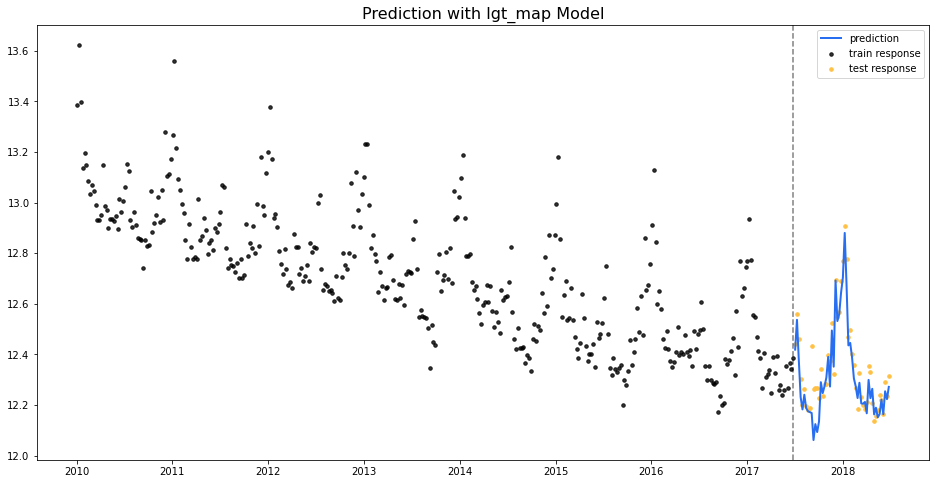

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2017-07-02,12.322463,12.417162,12.503900,12.371947,12.500739,12.592413,-0.134795,-0.035544,0.011254,-0.076839,-0.038115,0.007155
1,2017-07-09,12.432329,12.531252,12.629170,12.371316,12.487075,12.615657,-0.017795,0.086284,0.136031,-0.080061,-0.039714,0.007455
2,2017-07-16,12.285033,12.373289,12.484775,12.376721,12.481479,12.629811,-0.178256,-0.062092,-0.018518,-0.081304,-0.040330,0.007571
3,2017-07-23,12.116251,12.226054,12.306482,12.348136,12.483606,12.595078,-0.319755,-0.207373,-0.167128,-0.081262,-0.040309,0.007567
4,2017-07-30,12.093081,12.184415,12.272308,12.387711,12.485359,12.605736,-0.364810,-0.256366,-0.213950,-0.081704,-0.040528,0.007608


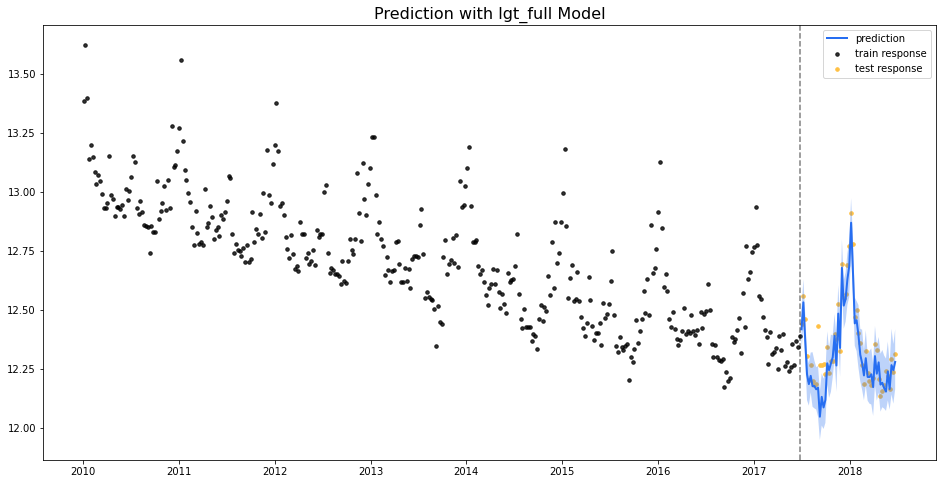

INFO:root:Guessed max_plate_nesting = 2


,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2017-07-02,12.302661,12.417004,12.530971,12.369199,12.482431,12.598652,-0.074682,-0.030320,0.003954,-0.071715,-0.036147,0.003697
1,2017-07-09,12.419404,12.516728,12.615133,12.372358,12.469458,12.579279,0.043433,0.091146,0.129133,-0.074723,-0.037663,0.003852
2,2017-07-16,12.261528,12.370023,12.491512,12.353682,12.475717,12.618406,-0.106839,-0.059284,-0.024901,-0.075882,-0.038248,0.003912
3,2017-07-23,12.141989,12.215446,12.299942,12.366390,12.458790,12.548244,-0.250259,-0.204083,-0.169713,-0.075844,-0.038228,0.003910
4,2017-07-30,12.083196,12.179203,12.281572,12.341660,12.465598,12.562797,-0.298268,-0.253017,-0.219047,-0.076255,-0.038436,0.003931


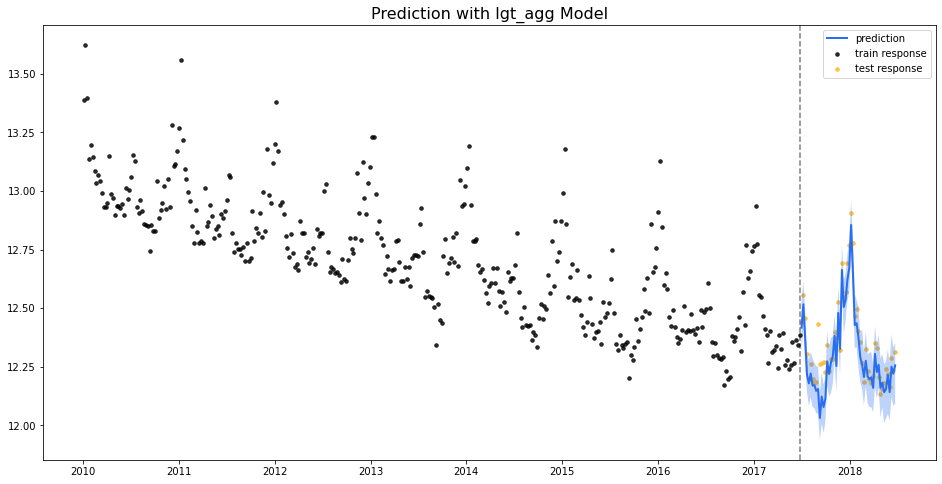

In [9]:
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data
import matplotlib.pyplot as plt

model_key_list = [model_key for model_key in config['uber_provided_example'].keys() if 'lgt_' in model_key]
# print(model_key_list)
for k in model_key_list:
    lgt = LGT(
        response_col=RESPONSE_COL,
        date_col=TIME_COL,
        regressor_col=[config['uber_provided_example'][k]['regressor_col'].get()],
        estimator=config['uber_provided_example'][k]['estimator'].get(),
        seasonality=config['uber_provided_example'][k]['seasonality'].get(),
        seed=config['uber_provided_example']['utils']['seed'].get()
    )
    if (config['uber_provided_example'][k]['estimator'].get() in ("stan-mcmc","pyro-svi")):
        lgt.fit(
            df=train_df,
            point_method=config['uber_provided_example'][k]['point_method'].get()
            )
    else:
        lgt.fit(
            df=train_df
            )
    pred_df = lgt.predict(df=test_df, decompose=True)
    display(pred_df.head())
    # plt.style.available
    ### open issue on orbit around the plt.style https://github.com/uber/orbit/issues/690
    plot_predicted_data(
        training_actual_df=train_df,
        predicted_df=pred_df,
        date_col=TIME_COL,
        actual_col=RESPONSE_COL,
        test_actual_df=test_df,
        title=f"Prediction with {k} Model",
        use_orbit_style=False);